# https://drive.google.com/drive/folders/1YavTQ-MHYoXdc-QAgaT1SjzKa_0dFi8W?usp=sharing

# Assignment 3: Autoencoders

For this assignment, alongwith the jupyter notebook you have to submit the weight files corresponding to each part i.e 6 weight files (mention the drive link containing these files at the start of the notebook). You also have to submit a .py file of assignment. You can download this jupyter notebook as a py file.


In [1]:
import glob
import os
import cv2
import numpy as np
import torch
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, datasets
import torch.optim as optim
from torchsummary import summary
import copy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython import display
from mpl_toolkits.axes_grid import ImageGrid

%matplotlib inline

C:\Anaconda\envs\DL\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Anaconda\envs\DL\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")
C:\Users\mahdi\AppData\Local\Temp\ipykernel_29836\1013545380.py:16: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import ImageGrid


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [4]:
def showImage(image):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show()


def showImageRow(images, title=None):
    plt.figure(figsize=(17, 15))
    if title is not None:
        plt.title(title)
    for i, image in enumerate(images, 1):
        plt.subplot(1, 5, i)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
    plt.show()


# Training Pipline


In [5]:
def train_model(model, dataloaders, criterion, optimizer, weight_path, num_epochs=25):
    val_loss_history = []
    train_loss_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    last_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1000000.0

    for epoch in tqdm(range(num_epochs)):
        print(f"Epoch {epoch} / {num_epochs - 1}", end="\t")

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            elif phase == "val":
                model.eval()

            running_loss = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print(f"{phase} loss: {epoch_loss:.4f}", end="\t")

            if phase == "val" and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, f"{weight_path}_best.pt")

            if phase == "val":
                val_loss_history.append(epoch_loss)
                last_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, f"{weight_path}_last.pt")

            if phase == "train":
                train_loss_history.append(epoch_loss)

        print()

    print("-" * 30)
    print(f"Training Complete")
    print(f"Best Validation Loss: {best_loss:.4f}")

    return best_model_wts, val_loss_history, train_loss_history


# Part 1: Image Completion

Image Completion is the task of filling missing parts of a given image with the help of information from the known parts of the image. This is an application that takes an image with a missing part as input and gives a completed image as the result.

We will be using Autoencoder to do this task. We will train our network on Images with missing parts passed with true images so that autoencoder generate an image with the missing parts.


### Data

The data we are using is [Flickr-Faces-HQ Dataset (FFHQ)](https://github.com/NVlabs/ffhq-dataset). It is an unlabelled dataset used for training GANs and other image generation algorithms. The original dataset has images of size 1024 by 1024 but we have only taken 128 by 128 images. Please download the dataset from this link (https://drive.google.com/drive/folders/1tg-Ur7d4vk1T8Bn0pPpUSQPxlPGBlGfv?usp=sharing)

Since the dataset is large (contains 70,000 image), you'll have to write a DataLoader that loads the data. For this you'll be using the Dataset and DataLoader class that are available in pytorch. For reference, you can get help from this link (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

The input to the network will consist of a image that is modified as shown below. The output label will be the original image.

![title](images/face_dataset.png)


In [87]:
def transform(image):
    image = image.T
    image = image.astype(np.float32) / 255
    return torch.tensor(image, device=device)


def rectangleAdder(image):
    img_width = image.shape[0]
    max_size = int(0.25 * img_width)
    start = np.random.randint(0, img_width - max_size, (2))
    rect_size = [random.randint(10, max_size), random.randint(10, max_size)]
    end = [a + b for a, b in zip(start, rect_size)]
    img_copy = image.copy()
    return cv2.rectangle(img_copy, start, end, (255, 255, 255), -1)


class FaceData(Dataset):
    def __init__(
        self, dataset_path, transform=None
    ):  # add additional parameters needed to load the dataset e.g dataset path
        # your code here.
        self.paths = dataset_path
        self.transform = transform

    def __len__(self):
        # your code here
        return len(self.paths)

    def __getitem__(self, idx):
        # your code here
        image_path = self.paths[idx]
        label = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        image = rectangleAdder(label)
        if self.transform:
            image, label = self.transform(image), self.transform(label)

        return image, label


You will define your autoencoder model here. For defining your custom model, you will find this link useful (https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html).

Note: For the decoder, you'll have to look into nn.ConvTranspose2d function for upsampling.


In [64]:
class ImageCompletionNet(nn.Module):
    def __init__(self):
        # your code here
        super().__init__()
        self.act = nn.ReLU()

        self.conv1 = nn.Conv2d(3, 16, 8, 2)
        self.bnorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 5, 1)
        self.bnorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, 2)
        self.bnorm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 5, 1)
        self.bnorm4 = nn.BatchNorm2d(64)

        self.tconv2 = nn.ConvTranspose2d(64, 64, 5, 1)
        self.tnorm2 = nn.BatchNorm2d(64)
        self.tconv3 = nn.ConvTranspose2d(64, 32, 3, 2)
        self.tnorm3 = nn.BatchNorm2d(32)
        self.tconv4 = nn.ConvTranspose2d(32, 16, 5, 1)
        self.tnorm4 = nn.BatchNorm2d(16)
        self.tconv5 = nn.ConvTranspose2d(16, 3, 8, 2)

    def forward(self, x):
        x = self.bnorm1(self.conv1(x))
        x = self.bnorm2(self.conv2(x))
        x = self.bnorm3(self.conv3(x))
        x = self.act(self.bnorm4(self.conv4(x)))

        x = self.act(self.tnorm2(self.tconv2(x)))
        x = self.tnorm3(self.tconv3(x))
        x = self.tnorm4(self.tconv4(x))
        x = torch.sigmoid(self.tconv5(x))

        return x


In [65]:
# Print your model here using summary from torchsummary
completionModel = ImageCompletionNet().to(device="cuda")
summary(completionModel, (3, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 61, 61]           3,088
       BatchNorm2d-2           [-1, 16, 61, 61]              32
            Conv2d-3           [-1, 32, 57, 57]          12,832
       BatchNorm2d-4           [-1, 32, 57, 57]              64
            Conv2d-5           [-1, 64, 28, 28]          18,496
       BatchNorm2d-6           [-1, 64, 28, 28]             128
            Conv2d-7          [-1, 128, 24, 24]         204,928
       BatchNorm2d-8          [-1, 128, 24, 24]             256
              ReLU-9          [-1, 128, 24, 24]               0
  ConvTranspose2d-10           [-1, 64, 28, 28]         204,864
      BatchNorm2d-11           [-1, 64, 28, 28]             128
  ConvTranspose2d-12           [-1, 32, 57, 57]          18,464
      BatchNorm2d-13           [-1, 32, 57, 57]              64
  ConvTranspose2d-14           [-1, 16,

In [66]:
BATCH_SIZE = 32
LEARNING_RATE = 0.03
EPOCHS = 10


Load the data using Custom Dataset class defined above and load your DataLoader. Divide the whole dataset into train, validation and test set.


In [29]:
data_paths = list(glob.glob("dataset/*/*.png"))
len_dataset = int(0.2 * len(data_paths))
# len_dataset = 1000
paths = {
    "train": FaceData(data_paths[:len_dataset], transform=transform),
    "val": FaceData(data_paths[len_dataset : len_dataset + 4000], transform=transform),
}

paths["train"][0]

dataloaders = {
    phase: DataLoader(paths[phase], BATCH_SIZE, shuffle=True, num_workers=0)
    for phase in ["train", "val"]
}


Define your training pipeline and evaluate your model using the validation loss. The choice of loss function and the hyperparameters is left at your discretion


In [109]:
def train_model(model, dataloaders, criterion, optimizer, weight_path, num_epochs=25):
    val_loss_history = []
    train_loss_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    last_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100

    for epoch in tqdm(range(num_epochs)):
        print(f"Epoch {epoch} / {num_epochs - 1}", end="\t")

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            elif phase == "val":
                model.eval()

            running_loss = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print(f"{phase} loss: {epoch_loss:.4f}", end="\t")

            if phase == "val" and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, weight_path)

            if phase == "val":
                val_loss_history.append(epoch_loss)

            if phase == "train":
                train_loss_history.append(epoch_loss)

        print()

    print("-" * 30)
    print(f"Training Complete")
    print(f"Best Validation Loss: {best_loss:.4f}")

    return best_model_wts, val_loss_history


In [523]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(completionModel.parameters(), lr=LEARNING_RATE)

best_wts, hist = train_model(
    completionModel, dataloaders, loss_function, optimizer, EPOCHS
)

# torch.save(best_wts, "task1_weights")
torch.save(best_wts, "task1_weights")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 / 9
train loss: 0.0245	val loss: 0.0994	

Epoch 1 / 9
train loss: 0.0117	val loss: 0.0505	

Epoch 2 / 9
train loss: 0.0089	val loss: 0.0389	

Epoch 3 / 9
train loss: 0.0079	val loss: 0.0357	

Epoch 4 / 9
train loss: 0.0072	val loss: 0.0317	

Epoch 5 / 9
train loss: 0.0069	val loss: 0.0315	

Epoch 6 / 9
train loss: 0.0067	val loss: 0.0301	

Epoch 7 / 9
train loss: 0.0064	val loss: 0.0279	

Epoch 8 / 9
train loss: 0.0059	val loss: 0.0269	

Epoch 9 / 9
train loss: 0.0056	val loss: 0.0246	

Training Complete
Best Validation Loss: 0.0246


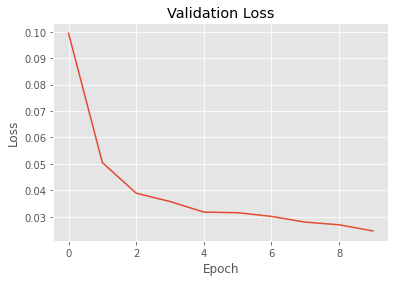

In [524]:
plt.plot(range(len(hist)), hist)
plt.title("Validation Loss")
plt.style.use("ggplot")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


Load your model using the weights you obtained from training and evaluate them on the test dataset. Your results will be evaluated on the basis of the image completion results. You will need to display your incomplete image along with the results in the form of 5x2 matrix (You can pick any random 5 images for display. Your image selector should be written as a method that generates random samples for testing)


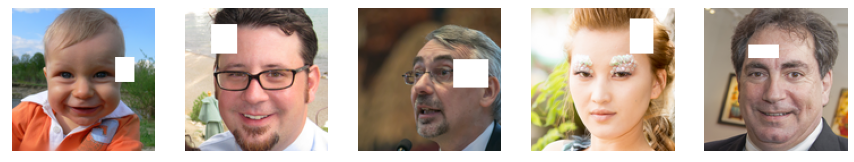

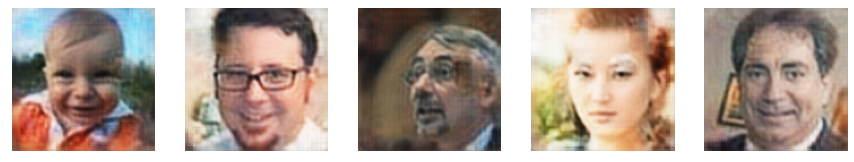

In [526]:
completionModel.load_state_dict(torch.load("task1_weights"))
completionModel.eval()

test_paths = list(glob.glob("dataset/69000/*.png"))[-5:]
test_dataset = FaceData(test_paths, transform=transform)

outputs = []
inputs = []

for image, _ in test_dataset:
    image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
    output = completionModel(image)
    outputs.append(output.detach().cpu().numpy()[0].T)
    inputs.append(image.detach().cpu().numpy()[0].T)

showImageRow(inputs)
showImageRow(outputs)


# Part 2: Image Denoising

An application of autoencoders includes image denoising. For this part you'll be using the person dataset that is a subset of the COCO dataset. You can download the datset using this link (https://drive.google.com/file/d/1gHTLS6dvEp31X2dWBdLrvGr--5WOm1Z3/view?usp=sharing). You'll use the images present in the dataset and generate your own labels through adding salt and pepper noise to the image. Your input to the model will be the noisy image created through using functions from opencv library and output will be the original image.

NOTE: This part is important and part 3 of the assignment uses the model that you'll build for denoising.


In [25]:
# ! COMMENTED OUT BECAUSE ONLY NEED TO RUN ONCE

# def generateSaltAndPepper(noise=0.125):
#     for path in tqdm(glob.glob("person_dataset/images/*.jpg")):
#         image = cv2.imread(path)

#         rows, cols = image.shape[:2]

#         num_pixels = int(rows * cols * noise)
#         color = 255
#         for i in range(num_pixels):
#             if i == num_pixels // 2:
#                 color = 0
#             y_coord=random.randint(0, rows - 1)
#             x_coord=random.randint(0, cols - 1)
#             image[y_coord, x_coord] = color


#         name = path.split("\\")
#         cv2.imwrite("person_dataset/noise/" + name[-1], image)

# generateSaltAndPepper(0.06)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [19]:
# Define your Dataset Class here as done in Part 1


class PersonData(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        label = cv2.cvtColor(cv2.imread(label_path), cv2.COLOR_BGR2RGB)
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        if self.transform:
            image, label = self.transform(image), self.transform(label)

        return image, label


In [20]:
# Define your model here
class DenoiseNet(nn.Module):
    def __init__(self):
        # your code here
        super().__init__()
        self.act = nn.ReLU()

        self.conv1 = nn.Conv2d(3, 16, 8, 2)
        self.bnorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 5, 1)
        self.bnorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, 2)
        self.bnorm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 5, 1)
        self.bnorm4 = nn.BatchNorm2d(128)

        self.tconv2 = nn.ConvTranspose2d(128, 64, 5, 1)
        self.tnorm2 = nn.BatchNorm2d(64)
        self.tconv3 = nn.ConvTranspose2d(64, 32, 3, 2)
        self.tnorm3 = nn.BatchNorm2d(32)
        self.tconv4 = nn.ConvTranspose2d(32, 16, 5, 1)
        self.tnorm4 = nn.BatchNorm2d(16)
        self.tconv5 = nn.ConvTranspose2d(16, 3, 8, 2)

    def forward(self, x):
        x = self.bnorm1(self.conv1(x))
        x = self.bnorm2(self.conv2(x))
        x = self.bnorm3(self.conv3(x))
        x = self.act(self.bnorm4(self.conv4(x)))

        x = self.act(self.tnorm2(self.tconv2(x)))
        x = self.tnorm3(self.tconv3(x))
        x = self.act(self.tnorm4(self.tconv4(x)))

        x = torch.sigmoid(self.tconv5(x))

        return x


In [21]:
# Print your model here using summary from torchsummary
denoiser = DenoiseNet().to(device=device)
summary(denoiser, (3, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 61, 61]           3,088
       BatchNorm2d-2           [-1, 16, 61, 61]              32
            Conv2d-3           [-1, 32, 57, 57]          12,832
       BatchNorm2d-4           [-1, 32, 57, 57]              64
            Conv2d-5           [-1, 64, 28, 28]          18,496
       BatchNorm2d-6           [-1, 64, 28, 28]             128
            Conv2d-7          [-1, 128, 24, 24]         204,928
       BatchNorm2d-8          [-1, 128, 24, 24]             256
              ReLU-9          [-1, 128, 24, 24]               0
  ConvTranspose2d-10           [-1, 64, 28, 28]         204,864
      BatchNorm2d-11           [-1, 64, 28, 28]             128
             ReLU-12           [-1, 64, 28, 28]               0
  ConvTranspose2d-13           [-1, 32, 57, 57]          18,464
      BatchNorm2d-14           [-1, 32,

In [72]:
BATCH_SIZE = 128
LEARNING_RATE = 0.01
EPOCHS = 10


In [74]:
def transform(image):
    image = cv2.resize(image, (128, 128))
    image = image.T
    image = image.astype(np.float32) / 255
    return torch.tensor(image, device=device)


transformer = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Resize((128, 128)),
    ]
)

image_paths = list(glob.glob("person_dataset/noise/*.jpg"))
label_paths = list(glob.glob("person_dataset/images/*.jpg"))
train_split = int(0.8 * len(image_paths))
# train_split = 100
coco_datasets = {
    "train": PersonData(
        image_paths=image_paths[:train_split],
        label_paths=label_paths[:train_split],
        transform=transformer,
    ),
    "val": PersonData(
        image_paths[train_split:], label_paths[train_split:], transform=transformer
    ),
}

dataloaders = {
    phase: DataLoader(coco_datasets[phase], BATCH_SIZE, shuffle=True, num_workers=0)
    for phase in ["train", "val"]
}


In [79]:
# Your training pipeline
loss_function = nn.MSELoss()
optimizer = optim.Adam(denoiser.parameters(), lr=LEARNING_RATE)
best_wts, val_hist, train_hist = train_model(
    denoiser, dataloaders, loss_function, optimizer, "task2", 20
)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 / 19	train loss: 0.0150	val loss: 0.0128	
Epoch 1 / 19	train loss: 0.0122	val loss: 0.0118	
Epoch 2 / 19	train loss: 0.0119	val loss: 0.0118	
Epoch 3 / 19	train loss: 0.0115	val loss: 0.0119	
Epoch 4 / 19	train loss: 0.0114	val loss: 0.0115	
Epoch 5 / 19	train loss: 0.0110	val loss: 0.0108	
Epoch 6 / 19	train loss: 0.0106	val loss: 0.0105	
Epoch 7 / 19	train loss: 0.0106	val loss: 0.0104	
Epoch 8 / 19	train loss: 0.0103	val loss: 0.0100	
Epoch 9 / 19	train loss: 0.0104	val loss: 0.0101	
Epoch 10 / 19	train loss: 0.0100	val loss: 0.0098	
Epoch 11 / 19	train loss: 0.0099	val loss: 0.0097	
Epoch 12 / 19	train loss: 0.0098	val loss: 0.0096	
Epoch 13 / 19	train loss: 0.0096	val loss: 0.0095	
Epoch 14 / 19	train loss: 0.0095	val loss: 0.0097	
Epoch 15 / 19	train loss: 0.0093	val loss: 0.0097	
Epoch 16 / 19	train loss: 0.0094	val loss: 0.0100	
Epoch 17 / 19	train loss: 0.0092	val loss: 0.0091	
Epoch 18 / 19	train loss: 0.0092	val loss: 0.0088	
Epoch 19 / 19	train loss: 0.0090	val loss

Load your model using the weights you obtained from training and evaluate them on the test dataset. Your results will be evaluated on the basis of the image denoising results. You will need to display your noise images along with the results in the form of 5x2 matrix (You can pick any random 5 images for display. Your image selector should be written as a method that generates random samples for testing)


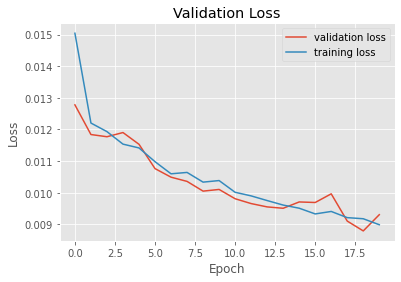

In [80]:
plt.plot(range(len(val_hist)), val_hist, label="validation loss")
plt.plot(range(len(train_hist)), train_hist, label="training loss")
plt.title("Validation Loss")
plt.style.use("ggplot")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


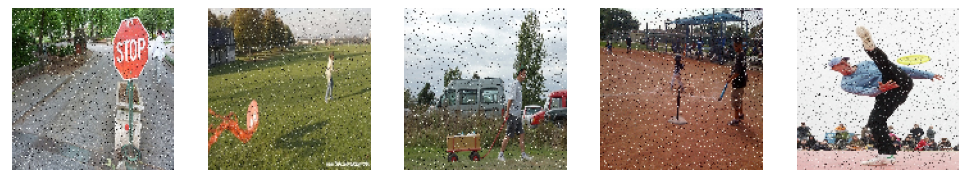

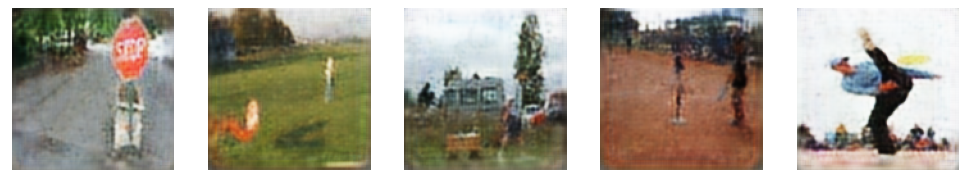

In [81]:
# Your testing pipeline
denoiser.load_state_dict(torch.load("task2_best.pt"))
denoiser.eval()

test_paths = list(glob.glob("person_dataset/noise/*.jpg"))[-5:]
label_paths = list(glob.glob("person_dataset/images/*.jpg"))[-5:]

outputs = []
inputs = []

for image_path, label_path in zip(test_paths, label_paths):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    inputs.append(cv2.resize(image, (128, 128)))
    image = transformer(image).to(device=device)
    image = image.reshape(1, *image.shape)
    output = denoiser(image)[0].permute(1, 2, 0).detach().cpu().numpy()
    outputs.append(output)

showImageRow(inputs)
showImageRow(outputs)


# Part 3: Background replacement/blur

Now that you're quite familiar with what encoders are, let's start with a real life example. Ever wondered how you can replace your background on zoom/google meet? How it actually works behind the scenes?

What these applications do is to run a segmentation model that detects humans and puts a mask on everything else. Although their models are highly optimised and light-weight (through pruning and quantization), we can build something similar with the current knowledge we have acquired in this course.

For this part of the assignment, you'll build an application that successfully segments the person in the video using a Resnet 34 based UNET model. The output from the segmentation model will act as a mask which we'll use as a basis for changing background and adding blur using cv2.Gaussianblur.

The end goal of this part of the assignment is to record a video of yourself and perform background replacement/blurring alongwith the denoising that you have done in part 3. You're required to submit two processed videos (one with the background blur and the other with background replacement) otherwise marks would be deducted from the assignment


In [5]:
# Define your Dataset as done in part 2 with little modifications to the output labels
# as now we'll have a binary mask for detecting humans.


class PersonData2(Dataset):
    def __init__(
        self, image_paths, label_paths, image_transform=None, label_transform=None
    ):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.image_transform = image_transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        label = cv2.cvtColor(cv2.imread(label_path), cv2.COLOR_BGR2RGB)
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        image = self.image_transform(image)
        label = self.label_transform(label)
        return image, label


### Resnet-34 UNET Model

You'll be required to build a resnet34 based UNET model. For this you'll be using the resnet34 model available in torchvision.models with pretrained weights enabled. A sample model based on an input size of 512x512 is shown below:

![title](images/unet.jpg)


In [6]:
# Define your Model Here
import torch.nn.functional as F


class UresNet(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()

        resnet_34 = models.resnet34(pretrained=pretrained)
        self.encoder_layers = list(resnet_34.children())[:-2]

        self.encoder1 = nn.Sequential(*self.encoder_layers[:3])
        self.encoder1_1x1 = nn.Conv2d(64, 128, 1, 1)
        self.encoder2 = nn.Sequential(*self.encoder_layers[3:5])
        self.encoder2_1x1 = nn.Conv2d(64, 128, 1, 1)
        self.encoder3 = nn.Sequential(self.encoder_layers[5])
        self.encoder3_1x1 = nn.Conv2d(128, 128, 1, 1)
        self.encoder4 = nn.Sequential(self.encoder_layers[6])
        self.encoder4_1x1 = nn.Conv2d(256, 128, 1, 1)
        self.encoder5 = nn.Sequential(self.encoder_layers[7])
        self.decoder1 = nn.ConvTranspose2d(512, 128, 2, 2)
        self.decoder2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.decoder3 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.decoder4 = nn.ConvTranspose2d(256, 128, 2, 2)

        self.out = nn.ConvTranspose2d(256, 1, 2, 2)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        enc5 = self.encoder5(enc4)

        enc4 = self.encoder4_1x1(enc4)
        x = self.decoder1(enc5)
        x = torch.cat([x, enc4], axis=1)

        enc3 = self.encoder3_1x1(enc3)
        x = self.decoder2(x)
        x = torch.cat([x, enc3], axis=1)

        enc2 = self.encoder2_1x1(enc2)
        x = self.decoder3(x)
        x = torch.cat([x, enc2], axis=1)

        enc1 = self.encoder1_1x1(enc1)
        x = self.decoder4(x)
        x = torch.cat([x, enc1], axis=1)

        x = self.out(x)
        return x


### Print your model here using summary from torchsummary


In [7]:
res = UresNet(True).to(device)
summary(res, (3, 512, 512))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
       BasicBlock-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

In [8]:
rows = 512
cols = 512


In [9]:
EPOCHS = 10
LEARNING_RATE = 0.001
BATCHSIZE = 8


In [10]:
# def image_transform(image):
#     image = cv2.resize(image, (rows, cols))
#     image = image.astype(np.float32) / 255
#     image = image.T
#     return torch.tensor(image, device=device)


# def label_transform(label):
#     label = cv2.resize(label[:, :, 0], (rows, cols))
#     label = label.astype(np.float32) / 255
#     label = label.reshape((1, rows, cols))
#     return torch.tensor(label, device=device)


data_transforms = {
    "image": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            transforms.Resize((rows, cols)),
        ]
    ),
    "label": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((rows, cols)),
            transforms.Grayscale(1),
        ]
    ),
}

image_paths = glob.glob("person_dataset/images/*.jpg")
label_paths = glob.glob("person_dataset/labels/*.jpg")
train_split = int(0.8 * len(image_paths))

# train_split = 1000

task3_datasets = {
    "train": PersonData2(
        image_paths[:train_split],
        label_paths[:train_split],
        data_transforms["image"],
        data_transforms["label"],
    ),
    "val": PersonData2(
        image_paths[train_split:],
        label_paths[train_split:],
        data_transforms["image"],
        data_transforms["label"],
    ),
}


dataloaders = {
    phase: DataLoader(task3_datasets[phase], BATCHSIZE, shuffle=True, num_workers=0)
    for phase in ["train", "val"]
}


The training loss you'll be using for this part iors a combination of Dice loss and binary cross entropy. Binary cross entropy is available in pytorch whereas you'll have to write the DICE loss yourself. A good article to understand dice loss (https://medium.com/ai-salon/understanding-dice-loss-for-crisp-boundary-detection-bb30c2e5f62b). The dice loss is mentioned below

![title](images/dice.png)


In [11]:
# Define your dice + bce loss here


def diceLoss(pred, target, smooth=1):
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    union = (pred ** 2).sum() + (target ** 2).sum()
    loss = 1 - ((2.0 * intersection + smooth) / (union + smooth))
    return loss


def weighted_loss(pred, target, bce_weight=0.5):
    bce = nn.functional.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = diceLoss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    return loss


In [12]:
import gc

gc.collect()

torch.cuda.empty_cache()


In [ ]:
criterion = weighted_loss
LEARNING_RATE = 0.001
EPOCHS = 10

optimizer = optim.Adam(res.parameters(), lr=LEARNING_RATE)

best_wts, val_hist, train_hist = train_model(
    res, dataloaders, criterion, optimizer, "task3", EPOCHS
)

torch.save(best_wts, "task3_weights.pt")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 / 9	train loss: 0.2441	val loss: 0.2220	
Epoch 1 / 9	train loss: 0.2023	val loss: 0.1911	
Epoch 2 / 9	train loss: 0.1835	val loss: 0.1836	
Epoch 3 / 9	train loss: 0.1673	val loss: 0.1956	
Epoch 4 / 9	train loss: 0.1519	val loss: 0.1724	
Epoch 5 / 9	train loss: 0.1429	val loss: 0.1772	
Epoch 6 / 9	train loss: 0.1334	val loss: 0.1609	
Epoch 7 / 9	train loss: 0.1221	val loss: 0.2029	
Epoch 8 / 9	train loss: 0.1157	val loss: 0.1652	
Epoch 9 / 9	train loss: 0.1113	val loss: 0.1609	
------------------------------
Training Complete
Best Validation Loss: 0.1609


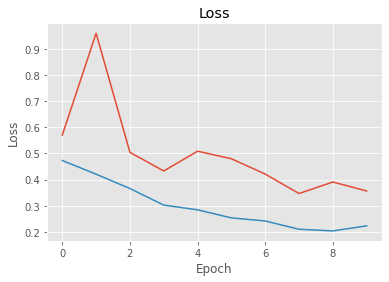

In [ ]:
plt.title("Loss")
plt.style.use("ggplot")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(range(len(val_hist)), val_hist)
plt.plot(range(len(train_hist)), train_hist)
plt.show()


Load your model using the weights you obtained from training and evaluate them on the test dataset. Your results will be evaluated on the basis of the segmentation masks created. You will need to display your original images along with their masks in the form of 5x2 matrix (You can pick any random 5 images for display. Your image selector should be written as a method that generates random samples for testing)


INPUT


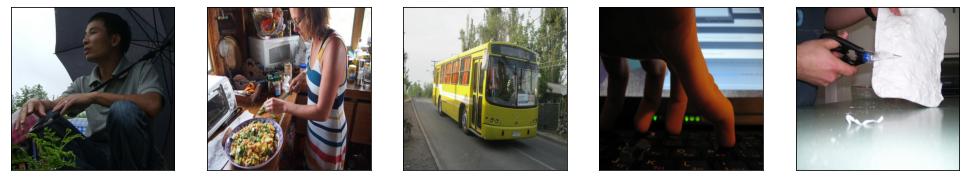

LABELS


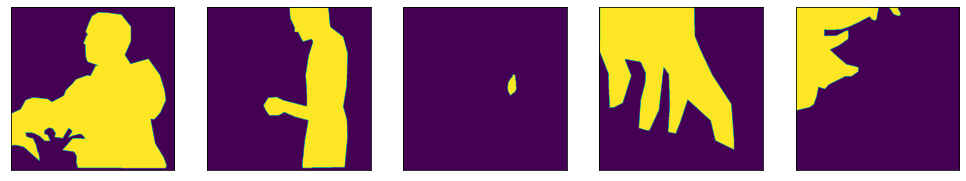

OUTPUT


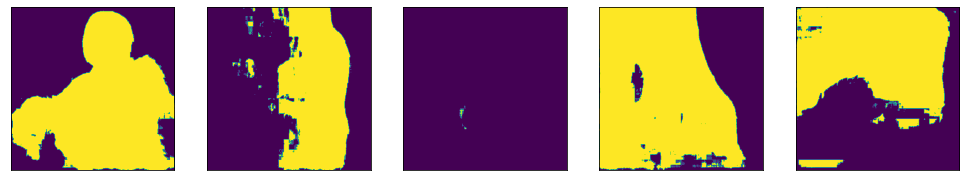

In [13]:
# Define your testing pipeline here
res.load_state_dict(torch.load("task3_best.pt"))
res.eval()

test_paths = list(glob.glob("person_dataset/images/*.jpg"))[train_split:]
label_paths = list(glob.glob("person_dataset/labels/*.jpg"))[train_split:]

idx = np.random.randint(0, len(test_paths), size=(5))

test_paths = [test_paths[i] for i in idx]
label_paths = [label_paths[i] for i in idx]

outputs = []
inputs = []
labels = []

for test_path, label_path in zip(test_paths, label_paths):
    test = cv2.cvtColor(cv2.imread(test_path), cv2.COLOR_BGR2RGB)
    output = res(data_transforms["image"](test).to(device).reshape(1, 3, rows, cols))
    outputs.append(torch.sigmoid(output[0][0]).detach().cpu().numpy())

    label = cv2.cvtColor(cv2.imread(label_path), cv2.COLOR_BGR2RGB)

    inputs.append(cv2.resize(test, (rows, cols)))
    label = cv2.resize(label, (rows, cols))
    labels.append(label[:, :, 0])

thres = 0.1
for output in outputs:
    output[output > thres] = 1
    output[output <= thres] = 0

print("INPUT")
showImageRow(inputs)
print("LABELS")
showImageRow(labels)
print("OUTPUT")
showImageRow(outputs)


### Completing the pipeline

Now that you've successfully built your segmentation model, we can move onto the exciting part where we'll be using the segmentation mask obtained from the model to blur/replace the background.

NOTE: For background replacement, you can use any picture of your choice (Surprise me!)


In [24]:
def get_output(image, model):
    transformer = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            transforms.Resize((512, 512)),
        ]
    )

    transformed = transformer(image).to(device)
    transformed = transformed.reshape((1, *transformed.shape))
    output = model(transformed)
    return output.detach().cpu().numpy()[0][0]


def threshold(image, thres=0.5):
    image[image > thres] = 1
    image[image <= thres] = 0
    return image


def background_blur(image, segmentation_model, thres=0.5):
    mask = get_output(image, segmentation_model)
    mask = threshold(mask, thres)

    image = cv2.resize(image, mask.shape)

    big_mask = np.zeros_like(image)
    big_mask[:, :, 0] = mask
    big_mask[:, :, 1] = mask
    big_mask[:, :, 2] = mask

    image_copy = image.copy()
    background = cv2.GaussianBlur(image_copy, (15, 15), 8)
    background[big_mask > 0] = image[big_mask > 0]

    return background


def background_replacement(image, new_background, segmentation_model, thres=0.5):
    mask = get_output(image, segmentation_model)
    mask = threshold(mask, thres)

    image = cv2.resize(image, mask.shape)
    big_mask = np.zeros_like(image)
    big_mask[:, :, 0] = mask
    big_mask[:, :, 1] = mask
    big_mask[:, :, 2] = mask

    back = new_background.copy()
    back = cv2.resize(back, image.shape[:2]) / 255

    back[big_mask > 0] = image[big_mask > 0]
    return back


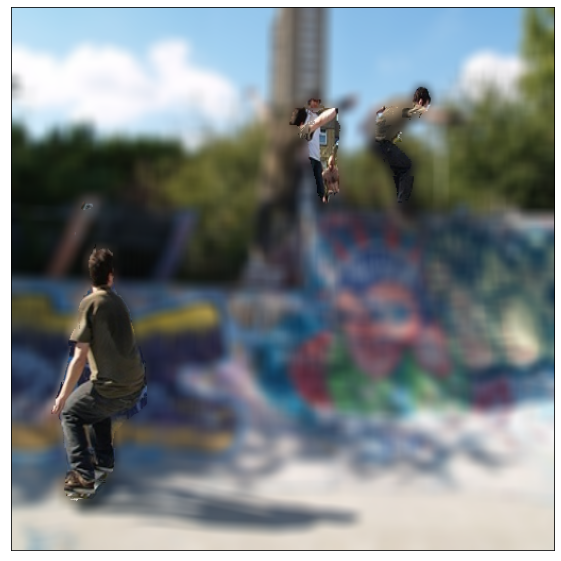

In [36]:
res.load_state_dict(torch.load("task3_best.pt"))

image = cv2.cvtColor(
    cv2.imread("person_dataset/images/000000000077.jpg"), cv2.COLOR_BGR2RGB
)

showImage(background_blur(image, res, 0.1))


(512, 512, 3)


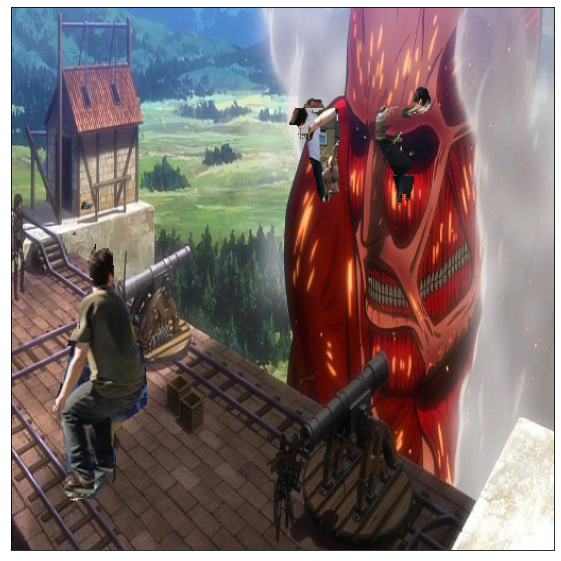

In [46]:
res.load_state_dict(torch.load("task3_best.pt"))

image = cv2.cvtColor(
    cv2.imread("person_dataset/images/000000000077.jpg"), cv2.COLOR_BGR2RGB
)

new_back = cv2.cvtColor(cv2.imread("new-back.jpg"), cv2.COLOR_BGR2RGB)
showImage(background_replacement(image, new_back, res, 0.1))


Now that you have successfully created some methods that can replace/blur the background. We can move on to building the complete pipeline. Record a video of your self (10 seconds long). Add salt and pepper noise to it as done in part 2 of the assignment. First perform a denoising using the denoising model we created in part 2 on all the frames of the video and then use the methods defined above to blur and replace the background.


In [23]:
def addNoise(image, noise=0.05):
    rows, cols = image.shape[:2]
    num_pixels = int(rows * cols * noise)
    color = 255
    for i in range(num_pixels):
        if i == num_pixels // 2:
            color = 0
        y_coord = random.randint(0, rows - 1)
        x_coord = random.randint(0, cols - 1)
        image[y_coord, x_coord] = color
    return image


def removeNoise(image, denoiser):
    transformer = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Resize((rows, cols)),
        ]
    )

    transformed = transformer(image).to(device)
    transformed = transformed.reshape((1, *transformed.shape))
    output = denoiser(transformed)
    return output[0].permute(1, 2, 0).detach().cpu().numpy()


In [25]:
# Define your video processing pipeline here
res.load_state_dict(torch.load("task3_best.pt"))
denoiser.load_state_dict(torch.load("task2_last.pt"))
vid_size = (512, 512)
capture = cv2.VideoCapture("talal.mp4")
outputFile = cv2.VideoWriter(
    "out-blurred.avi", cv2.VideoWriter_fourcc(*"MJPG"), 30, vid_size
)

if capture.isOpened():
    ret, frame = capture.read()
else:
    ret = False

while ret:
    ret, frame = capture.read()
    if not ret:
        break

    frame = cv2.resize(frame, (512, 512))
    noisy = addNoise(frame, 0)
    noisy = cv2.resize(noisy, (512, 512))
    noisynt = removeNoise(noisy, denoiser)
    blurred = background_blur(frame, res, 0.1)
    blurred = (blurred * 255).astype(np.uint8)
    outputFile.write(blurred)

capture.release()
outputFile.release()


In [29]:
res.load_state_dict(torch.load("task3_best.pt"))
denoiser.load_state_dict(torch.load("task2_last.pt"))

vid_size = (512, 512)
background = cv2.imread("talal_pic.jpeg")

capture = cv2.VideoCapture("talal.mp4")
outputFile = cv2.VideoWriter(
    "out-newBackground.avi", cv2.VideoWriter_fourcc(*"MJPG"), 30, vid_size
)

if capture.isOpened():
    ret, frame = capture.read()
else:
    ret = False

while ret:
    ret, frame = capture.read()
    if not ret:
        break

    frame = cv2.resize(frame, (512, 512))
    noisy = addNoise(frame, 0)
    noisynt = removeNoise(noisy, denoiser)
    modded = background_replacement(noisynt, background, res, 0.05)
    output = (modded * 255).astype(np.uint8)
    outputFile.write(output)

capture.release()
outputFile.release()


# Part 4: Background blur via Autoencoders

Hurray! Now that now you're here, you should be proud of yourself that you built your first real world application through using AI. What you're supposed to do in this part of the assignment is to use the model you created in Part 3 and extend that to reconstruct images with a blurred background instead of adding a post-processing pipeline to achieve this (hint: change the number of classes in the final layer).

You will be using the same person dataset that you have used in the previous parts but now instead of predicting output masks, you'll be predicting images with blurred background. You can generate the output labels for this task using the blurring pipeline you made in part 3.


In [68]:
# Define your Dataset class here


class BlurDataset(Dataset):
    def __init__(
        self, image_paths, label_paths, image_transform=None, label_transform=None
    ):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.image_transform = image_transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        label = cv2.cvtColor(cv2.imread(label_path), cv2.COLOR_BGR2RGB)
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        image = self.image_transform(image)
        label = self.label_transform(label)
        return image, label


### Create Blurred data


In [39]:
# Commented out because only need to run this once

# image_paths = glob.glob("person_dataset/images/*")
# mask_paths = glob.glob("person_dataset/labels/*")

# for i in tqdm(range(len(image_paths))):
#     mask_path = mask_paths[i]
#     image_path = image_paths[i]

#     image = cv2.imread(image_path)
#     mask = cv2.imread(mask_path)
#     image_copy = image.copy()
#     background = cv2.GaussianBlur(image_copy, (23, 23), 20)
#     background[mask > 0] = image[mask > 0]
#     file_name = image_path.split("\\")[-1]
#     cv2.imwrite("person_dataset/blur/" + file_name, background)


### Defining Model for part 4


In [69]:
# Define your Model Class here
# Define your Model Here
import torch.nn.functional as F


class BlurNet(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()

        resnet_34 = models.resnet34(pretrained=pretrained)
        self.encoder_layers = list(resnet_34.children())[:-2]

        self.encoder1 = nn.Sequential(*self.encoder_layers[:3])
        self.encoder1_1x1 = nn.Conv2d(64, 128, 1, 1)
        self.encoder2 = nn.Sequential(*self.encoder_layers[3:5])
        self.encoder2_1x1 = nn.Conv2d(64, 128, 1, 1)
        self.encoder3 = nn.Sequential(self.encoder_layers[5])
        self.encoder3_1x1 = nn.Conv2d(128, 128, 1, 1)
        self.encoder4 = nn.Sequential(self.encoder_layers[6])
        self.encoder4_1x1 = nn.Conv2d(256, 128, 1, 1)
        self.encoder5 = nn.Sequential(self.encoder_layers[7])
        self.decoder1 = nn.ConvTranspose2d(512, 128, 2, 2)
        self.decoder2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.decoder3 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.decoder4 = nn.ConvTranspose2d(256, 128, 2, 2)

        self.out = nn.ConvTranspose2d(256, 3, 2, 2)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        enc5 = self.encoder5(enc4)

        enc4 = self.encoder4_1x1(enc4)
        x = self.decoder1(enc5)
        x = torch.cat([x, enc4], axis=1)

        enc3 = self.encoder3_1x1(enc3)
        x = self.decoder2(x)
        x = torch.cat([x, enc3], axis=1)

        enc2 = self.encoder2_1x1(enc2)
        x = self.decoder3(x)
        x = torch.cat([x, enc2], axis=1)

        enc1 = self.encoder1_1x1(enc1)
        x = self.decoder4(x)
        x = torch.cat([x, enc1], axis=1)

        x = torch.sigmoid(self.out(x))
        return x


In [70]:
# print your model here with summary from torchsummary
blurer = BlurNet().to(device)
summary(blurer, (3, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [72]:
BATCH_SIZE = 16

# Write your training pipeline here
task4_transformer = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((128, 128)),
        transforms.ConvertImageDtype(torch.float32),
    ]
)

image_paths = glob.glob("person_dataset/images/*")
label_paths = glob.glob("person_dataset/blur/*")


train_split = int(0.8 * len(image_paths))
train_split = 1000
task4_datasets = {
    "train": BlurDataset(
        image_paths[:train_split],
        label_paths[:train_split],
        task4_transformer,
        task4_transformer,
    ),
    "val": BlurDataset(
        image_paths[train_split:],
        label_paths[train_split:],
        task4_transformer,
        task4_transformer,
    ),
}

task4_datasets["train"][0]

dataloaders = {
    phase: DataLoader(task4_datasets[phase], BATCH_SIZE, shuffle=True, num_workers=0)
    for phase in ["train", "val"]
}


In [60]:
import gc

gc.collect()

torch.cuda.empty_cache()


In [61]:
LEARNING_RATE = 0.001
EPOCHS = 5

criterion = nn.MSELoss()
optimizer = optim.Adam(blurer.parameters(), lr=LEARNING_RATE)

best_wts, val_hist, train_hist = train_model(
    blurer, dataloaders, criterion, optimizer, "task4", EPOCHS
)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 / 4	train loss: 0.0108	val loss: 0.0034	
Epoch 1 / 4	train loss: 0.0043	val loss: 0.0033	
Epoch 2 / 4	train loss: 0.0047	val loss: 0.0039	
Epoch 3 / 4	train loss: 0.0039	val loss: 0.0026	
Epoch 4 / 4	train loss: 0.0040	val loss: 0.0029	
------------------------------
Training Complete
Best Validation Loss: 0.0026


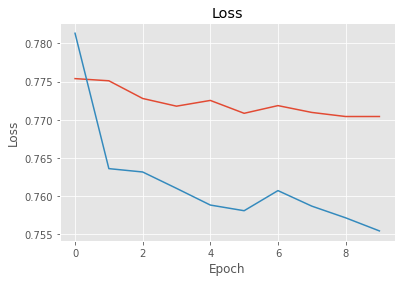

In [55]:
plt.title("Loss")
plt.style.use("ggplot")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(range(len(val_hist)), val_hist)
plt.plot(range(len(train_hist)), train_hist)
plt.show()


Load your model using the weights you obtained from training and evaluate them on the test dataset. Your results will be evaluated on the basis of the blurred images created. You will need to display your original images along with their background blurred couterparts in the form of 5x2 matrix (You can pick any random 5 images for display. Your image selector should be written as a method that generates random samples for testing)


INPUT


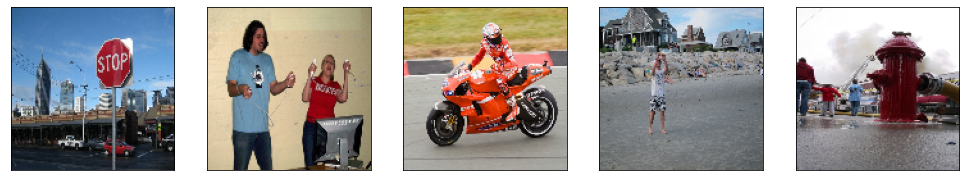

OUTPUTS


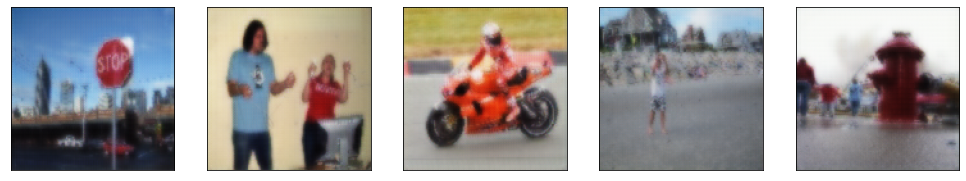

In [75]:
# Write your testing pipeline here
blurer.load_state_dict(torch.load("task4_best.pt"))
blurer.eval()

test_paths = list(glob.glob("person_dataset/images/*.jpg"))[train_split:]
label_paths = list(glob.glob("person_dataset/blur/*.jpg"))[train_split:]

idx = np.random.randint(0, len(test_paths), size=(5))

test_paths = [test_paths[i] for i in idx]
label_paths = [label_paths[i] for i in idx]

outputs = []
inputs = []
labels = []

for test_path, label_path in zip(test_paths, label_paths):
    test = cv2.cvtColor(cv2.imread(test_path), cv2.COLOR_BGR2RGB)
    output = blurer(task4_transformer(test).to(device).reshape(1, 3, 128, 128))
    outputs.append(output[0].permute(1, 2, 0).detach().cpu().numpy())
    label = cv2.cvtColor(cv2.imread(label_path), cv2.COLOR_BGR2RGB)

    inputs.append(cv2.resize(test, (128, 128)))
    label = cv2.resize(label, (128, 128))
    labels.append(label)

print("INPUT")
showImageRow(inputs)
print("OUTPUTS")
showImageRow(outputs)


# Part 5: OpenVino Model Optimisation

You have to optimise one of the neural networks that you trained in programming assignment 2 using OpenVino toolkit as described in the tutorial. You have to produce weights for FP16 and FP32 precision. You also have to report the inference time of both models and verify that the pytorch's output is same as optimised model's.


In [ ]:
!pip3 install onnxruntime
!pip3 install onnxruntime-gpu

In [ ]:
res.eval()
res.load_state_dict(torch.load("/content/drive/MyDrive/task3_best.pt", map_location=device))

image = cv2.imread("/content/person_dataset/images/000000000061.jpg")
transformer = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            transforms.Resize((rows, cols)),
        ]
        )
x = transformer(image).to(device)
x = x.reshape((1, *x.shape))
torch.onnx._export(res, x, 'uresnet.onnx', export_params=True)
!ls -l uresnet.onnx

-rw-r--r-- 1 root root 88006506 Mar 16 17:25 uresnet.onnx


In [ ]:
import time
start = time.time()
for i in range(0,10):
    y = res(x)
end = time.time()
print(" Inference FPS = {}".format(1/((end - start)/10)))

 Inference FPS = 0.9938697561501423


In [ ]:
!sudo apt install intel-openvino-runtime-ubuntu20-2021.1.105

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package intel-openvino-runtime-ubuntu20-2021.1.105
E: Couldn't find any package by glob 'intel-openvino-runtime-ubuntu20-2021.1.105'
E: Couldn't find any package by regex 'intel-openvino-runtime-ubuntu20-2021.1.105'


In [ ]:
!python openvino_2021/deployment_tools/model_optimizer/mo_onnx.py --input_model resnet18.onnx --scale_values=[58.395,57.120,57.375] --mean_values=[123.675,116.28,103.53] --reverse_input_channels --disable_resnet

python3: can't open file 'openvino_2021/deployment_tools/model_optimizer/mo_onnx.py': [Errno 2] No such file or directory
